In [14]:
import torchvision as tv
import torch
import torchvision.transforms as transforms

num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([
    transforms.ToTensor(),
 ])  

trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 7 * 7, 12)  # FC layer to latent space

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

class ClassifierEncoder(nn.Module):
    def __init__(self):
        super(ClassifierEncoder, self).__init__()
        self.encoder = Encoder()
        self.fc1 = nn.Linear(12, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# initialize the NN
model = ClassifierEncoder().to(device)
print(model)

ClassifierEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=196, out_features=12, bias=True)
  )
  (fc1): Linear(in_features=12, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)


In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [1/20], Train Loss: 0.9948, Train Accuracy: 68.21%, Test Loss: 0.4319, Test Accuracy: 87.25%
Epoch [2/20], Train Loss: 0.3802, Train Accuracy: 88.55%, Test Loss: 0.3174, Test Accuracy: 90.61%
Epoch [3/20], Train Loss: 0.3016, Train Accuracy: 91.03%, Test Loss: 0.2614, Test Accuracy: 92.23%
Epoch [4/20], Train Loss: 0.2535, Train Accuracy: 92.58%, Test Loss: 0.2212, Test Accuracy: 93.64%
Epoch [5/20], Train Loss: 0.2213, Train Accuracy: 93.50%, Test Loss: 0.1940, Test Accuracy: 94.36%
Epoch [6/20], Train Loss: 0.2002, Train Accuracy: 94.10%, Test Loss: 0.1759, Test Accuracy: 94.72%
Epoch [7/20], Train Loss: 0.1850, Train Accuracy: 94.55%, Test Loss: 0.1663, Test Accuracy: 94.98%
Epoch [8/20], Train Loss: 0.1735, Train Accuracy: 94.90%, Test Loss: 0.1531, Test Accuracy: 95.41%
Epoch [9/20], Train Loss: 0.1643, Train Accuracy: 95.19%, Test Loss: 0.1446, Test Accuracy: 95.51%
Epoch [10/20], Train Loss: 0.1560, Train Accuracy: 95.37%, Test Loss: 0.1419, Test Accuracy: 95.69%
Epoch [11

In [17]:
list(model.parameters())[0]

Parameter containing:
tensor([[[[-2.5719e-01,  5.6812e-01,  5.7730e-01],
          [ 7.4085e-01,  9.4100e-01,  3.7629e-01],
          [ 8.8197e-01,  9.3287e-01,  5.7474e-01]]],


        [[[ 7.5925e-01,  2.0912e-01,  6.8467e-01],
          [ 4.7027e-01, -4.5911e-02,  4.5750e-01],
          [-5.7563e-02, -2.2169e-01,  1.5051e-02]]],


        [[[ 5.0431e-01,  2.6070e-01,  2.3079e-01],
          [ 4.7202e-01,  5.1184e-01, -5.7204e-02],
          [ 9.4543e-01,  3.8366e-01,  6.6424e-01]]],


        [[[ 2.7216e-01,  4.0876e-01,  2.0100e-01],
          [ 7.9560e-01,  8.7653e-01,  7.9711e-02],
          [ 8.2698e-01,  6.7020e-01,  3.4716e-01]]],


        [[[-3.0310e-01,  1.6353e-01,  5.0561e-01],
          [ 5.4774e-01,  9.2513e-01,  8.7536e-01],
          [ 5.6693e-01,  5.3684e-01,  4.7643e-01]]],


        [[[ 1.7002e-01,  2.9628e-01, -1.6272e-01],
          [ 6.7825e-01,  9.6397e-01,  4.0890e-01],
          [ 8.4283e-01,  9.9485e-01,  6.5939e-01]]],


        [[[ 1.7486e-01, -1.2259e-02,

In [18]:
for param in model.parameters():
    param.requires_grad = False

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(10, 4 * 7 * 7)  # FC layer from latent space
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 4, 7, 7)
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        return x

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = model(x)
        x = self.decoder(x)
        return x

conv_autoencoder = ConvAutoencoder().to(device)

In [19]:
# specify loss function
criterion = nn.L1Loss()

# specify loss function
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=0.001)

n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = conv_autoencoder(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.307064
Epoch: 2 	Training Loss: 1.927468
Epoch: 3 	Training Loss: 1.873870
Epoch: 4 	Training Loss: 1.847350
Epoch: 5 	Training Loss: 1.832650
Epoch: 6 	Training Loss: 1.822704
Epoch: 7 	Training Loss: 1.815739
Epoch: 8 	Training Loss: 1.809797
Epoch: 9 	Training Loss: 1.805194
Epoch: 10 	Training Loss: 1.801399
Epoch: 11 	Training Loss: 1.797624
Epoch: 12 	Training Loss: 1.794174
Epoch: 13 	Training Loss: 1.790617
Epoch: 14 	Training Loss: 1.788282
Epoch: 15 	Training Loss: 1.786572
Epoch: 16 	Training Loss: 1.784726
Epoch: 17 	Training Loss: 1.783074
Epoch: 18 	Training Loss: 1.781802
Epoch: 19 	Training Loss: 1.780821
Epoch: 20 	Training Loss: 1.779805


In [20]:
list(model.parameters())[0]

Parameter containing:
tensor([[[[-2.5719e-01,  5.6812e-01,  5.7730e-01],
          [ 7.4085e-01,  9.4100e-01,  3.7629e-01],
          [ 8.8197e-01,  9.3287e-01,  5.7474e-01]]],


        [[[ 7.5925e-01,  2.0912e-01,  6.8467e-01],
          [ 4.7027e-01, -4.5911e-02,  4.5750e-01],
          [-5.7563e-02, -2.2169e-01,  1.5051e-02]]],


        [[[ 5.0431e-01,  2.6070e-01,  2.3079e-01],
          [ 4.7202e-01,  5.1184e-01, -5.7204e-02],
          [ 9.4543e-01,  3.8366e-01,  6.6424e-01]]],


        [[[ 2.7216e-01,  4.0876e-01,  2.0100e-01],
          [ 7.9560e-01,  8.7653e-01,  7.9711e-02],
          [ 8.2698e-01,  6.7020e-01,  3.4716e-01]]],


        [[[-3.0310e-01,  1.6353e-01,  5.0561e-01],
          [ 5.4774e-01,  9.2513e-01,  8.7536e-01],
          [ 5.6693e-01,  5.3684e-01,  4.7643e-01]]],


        [[[ 1.7002e-01,  2.9628e-01, -1.6272e-01],
          [ 6.7825e-01,  9.6397e-01,  4.0890e-01],
          [ 8.4283e-01,  9.9485e-01,  6.5939e-01]]],


        [[[ 1.7486e-01, -1.2259e-02,

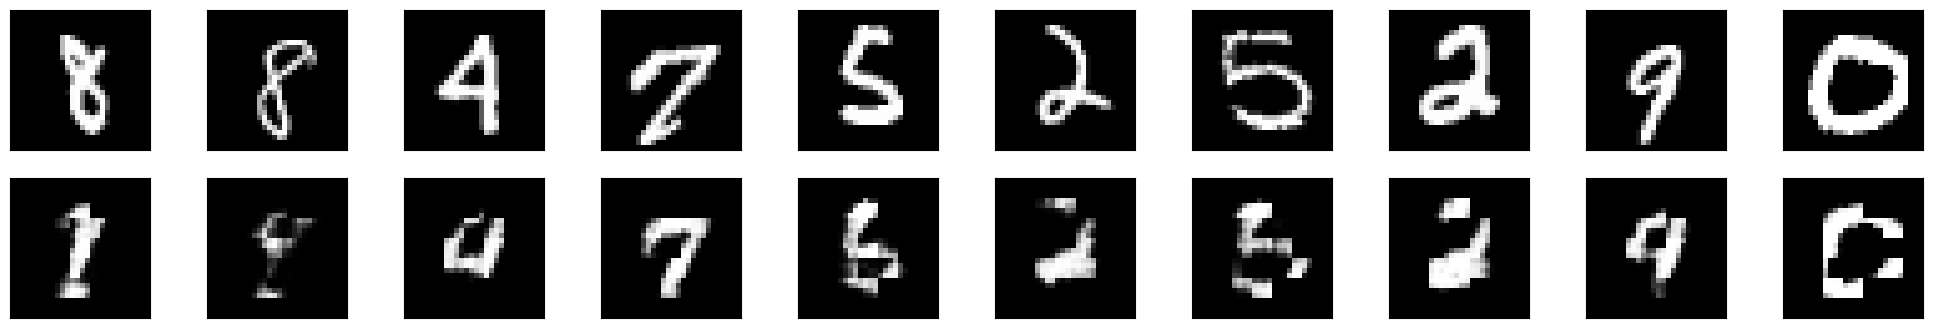

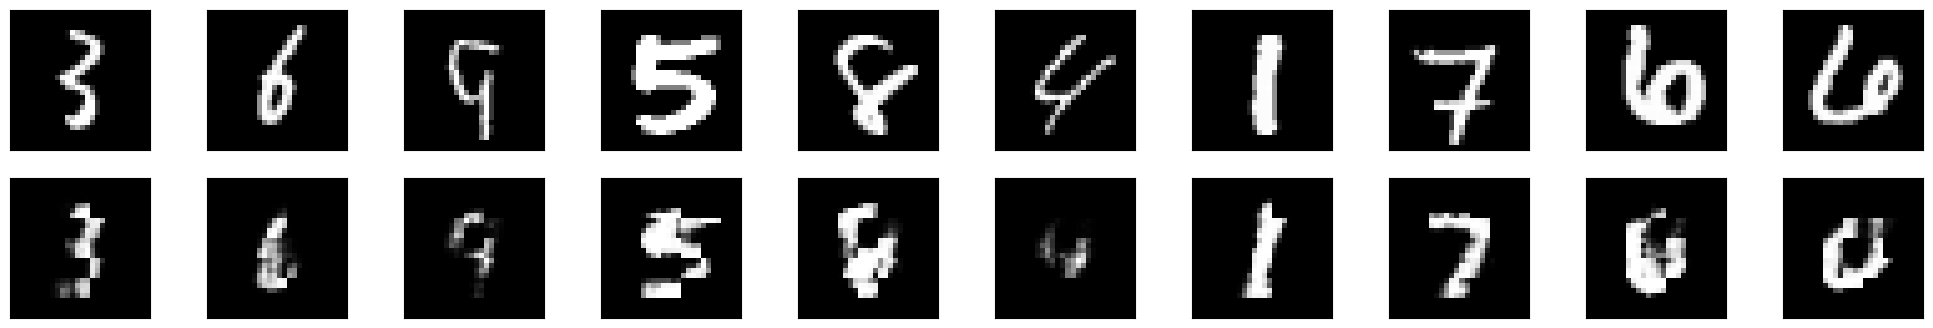

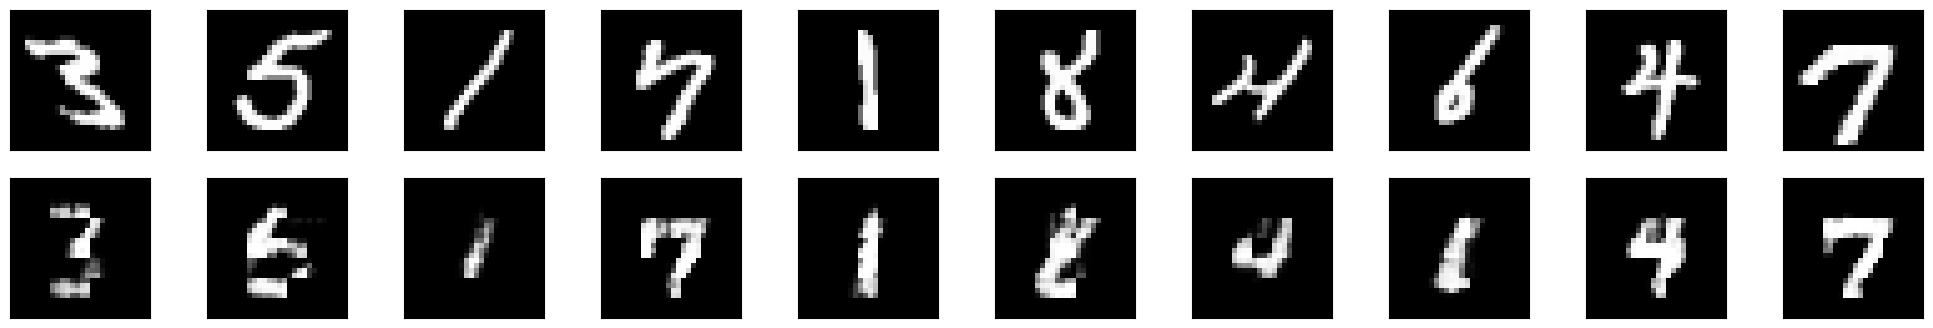

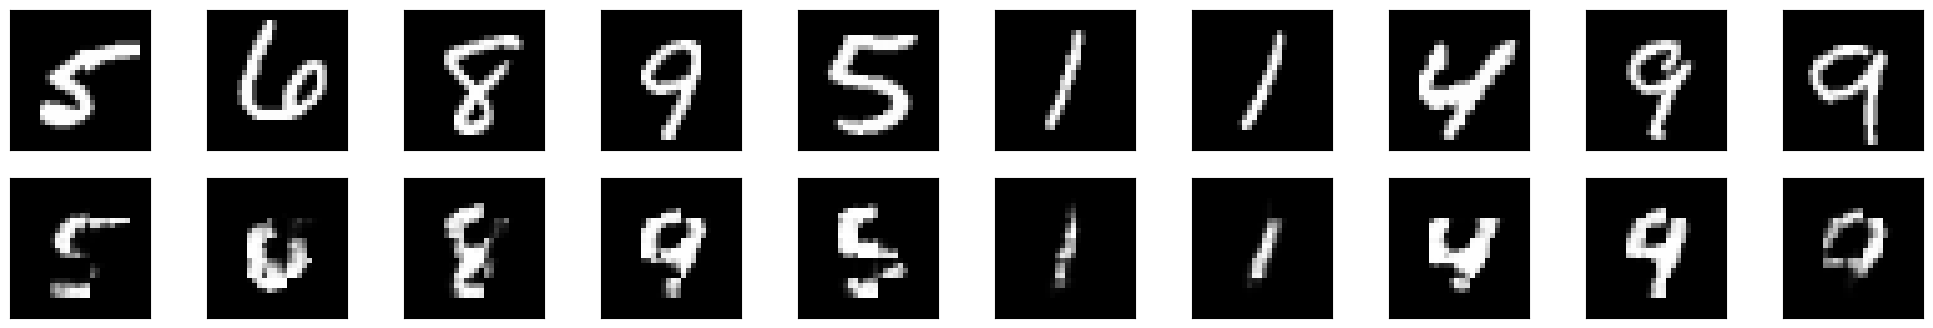

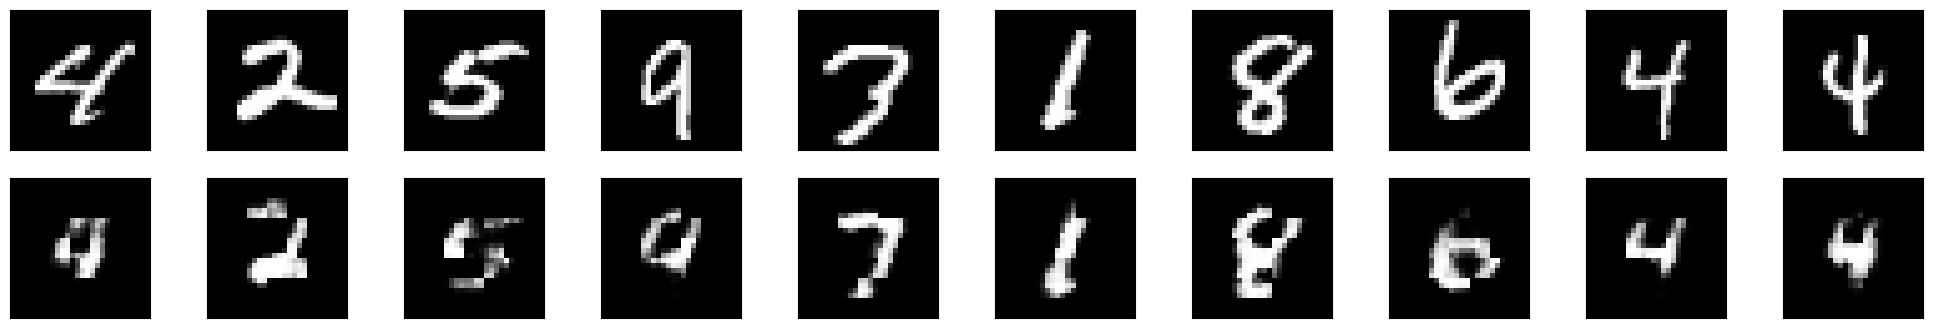

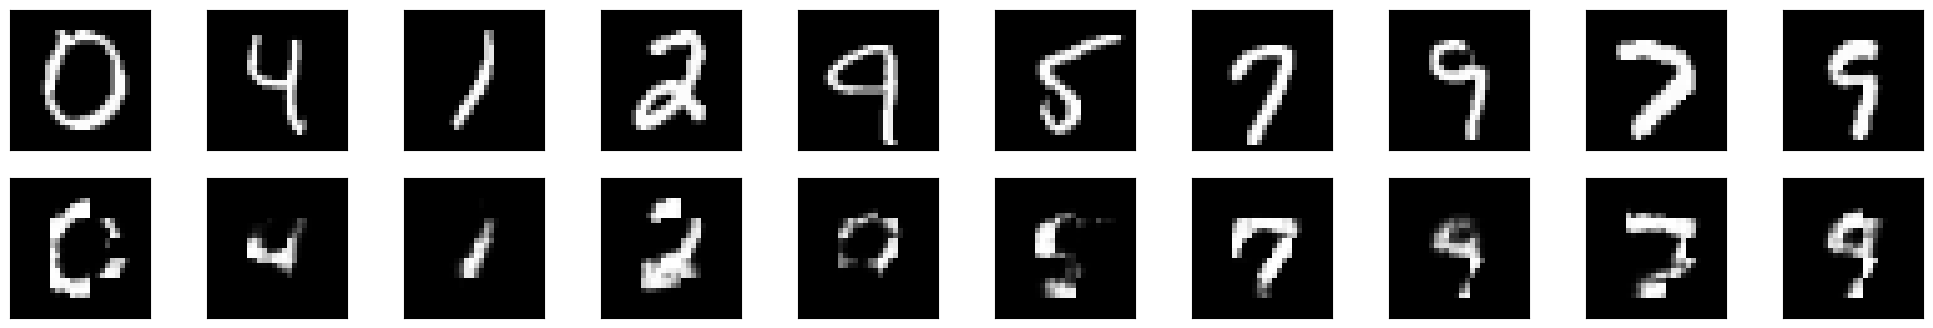

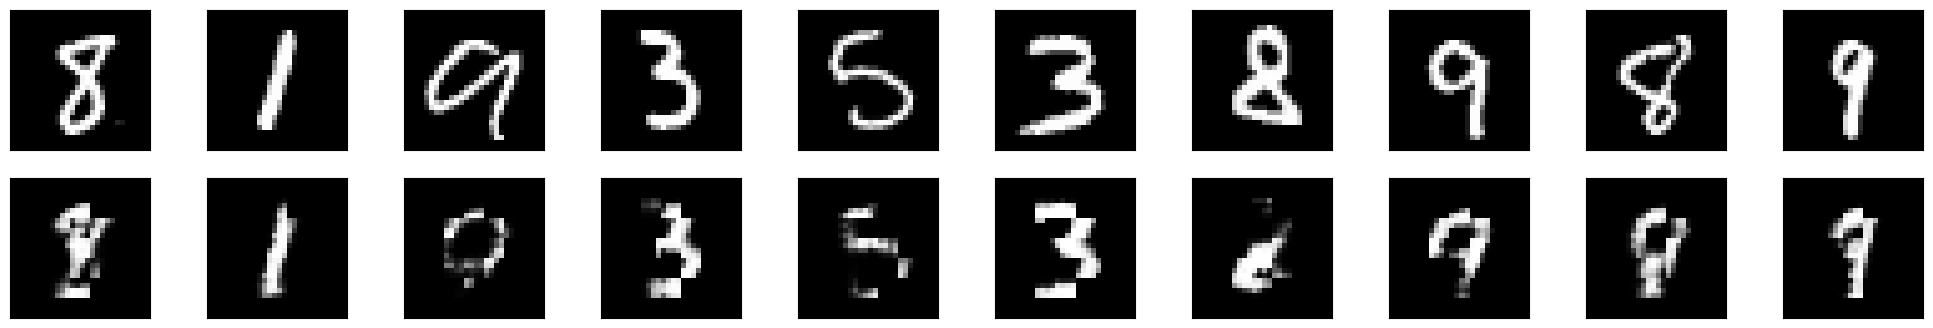

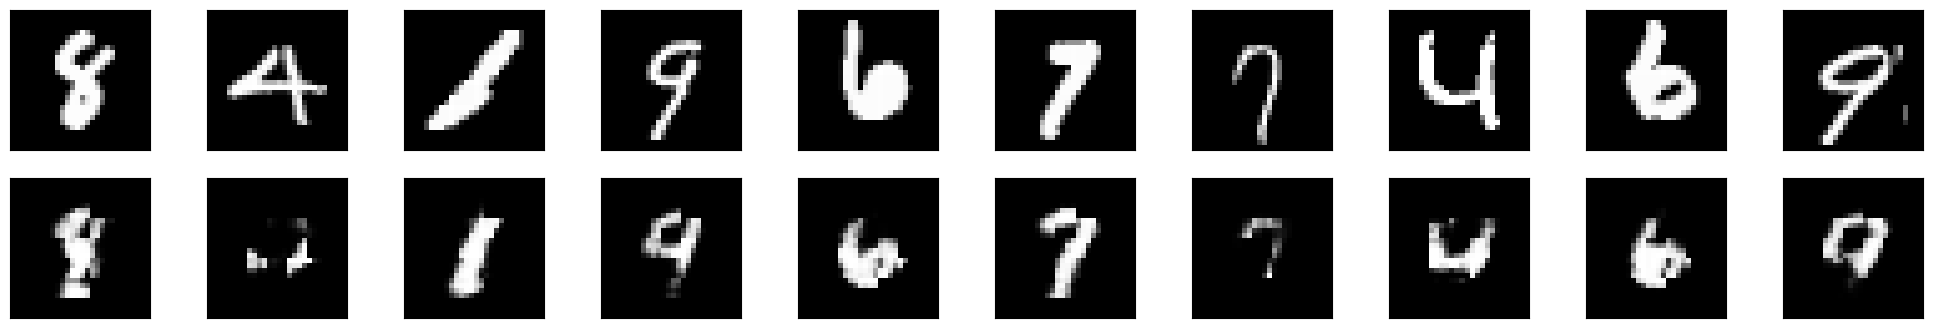

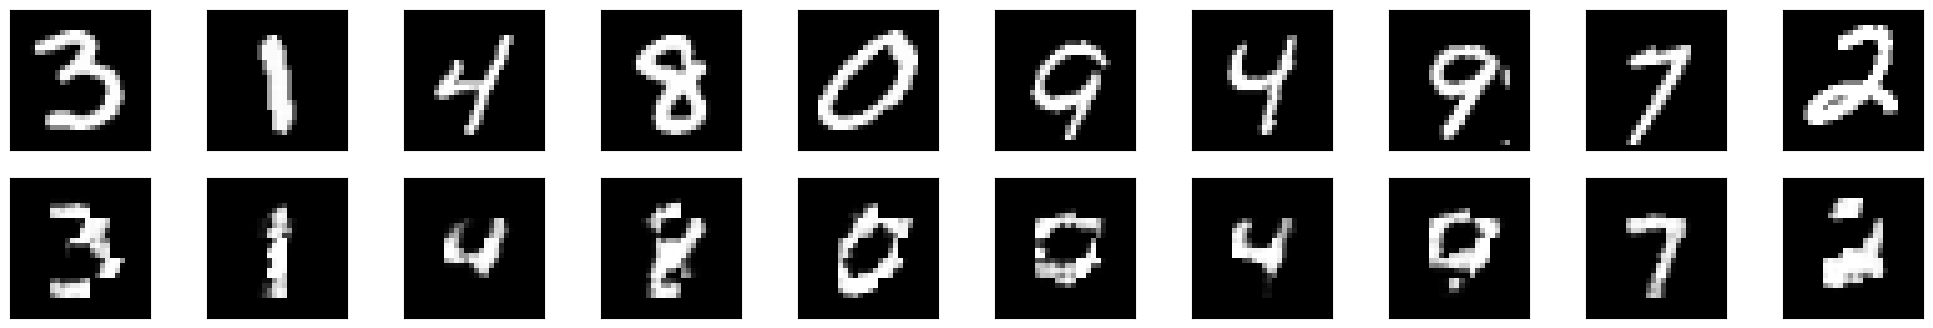

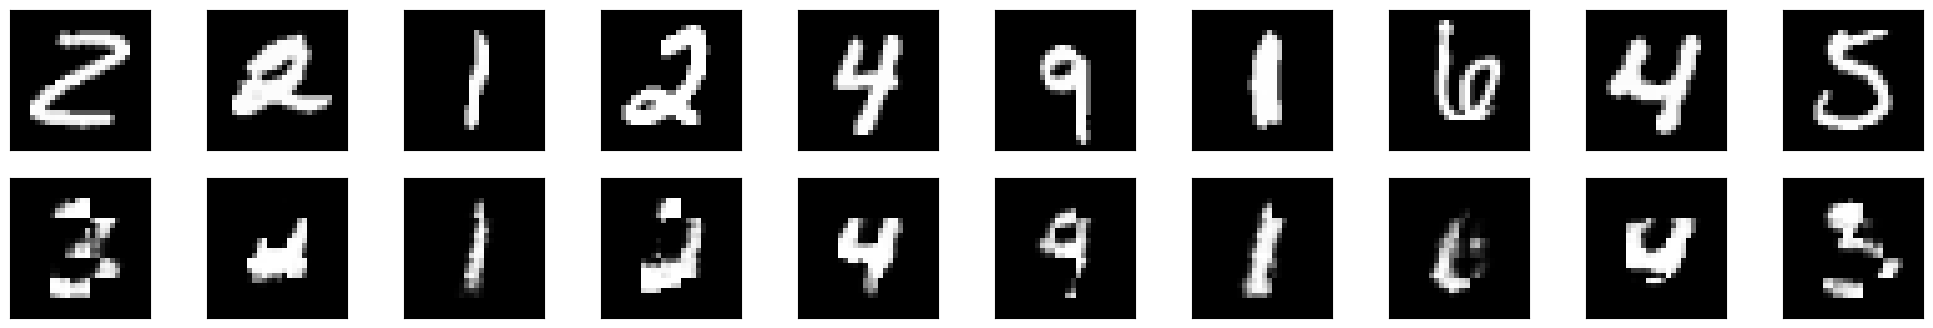

In [21]:
import numpy as np
import matplotlib.pyplot as plt


# obtain one batch of test images
dataiter = iter(test_loader)

for x in range(10):
    images, labels = next(dataiter)

    # get sample outputs
    images = images.to(device)

    output = conv_autoencoder(images)
    # prep images for display
    images = images.cpu().numpy()

    # output is resized into a batch of iages
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
